## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
from datetime import datetime

DEVICE_NAME = 'cuda:0'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
model_name = f'gru_attention_{now}'

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.data import Field, BucketIterator
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import generate_translation, remove_tech_tokens, get_text, parse_tensorboard_logs, plot_metrics

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
idx = 9
print(' '.join(train_data.examples[idx].src))
print(' '.join(train_data.examples[idx].trg))

также предлагается доставка продуктов , услуги прачечной и гладильные услуги .
other facilities offered at the property include grocery deliveries , laundry and ironing services .


Let's check the length distributions:

Length distribution in Train data
Max source length: 73
Max target length: 89


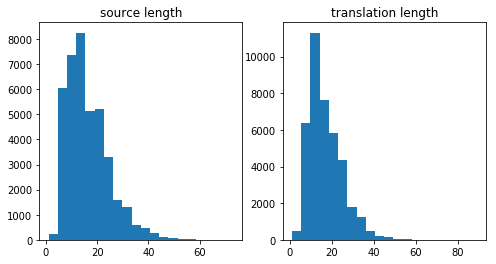

In [14]:
src_length = list(map(len, [x.src for x in train_data.examples]))
trg_length = list(map(len, [x.trg for x in train_data.examples]))

print('Length distribution in Train data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data
Max source length: 80
Max target length: 99


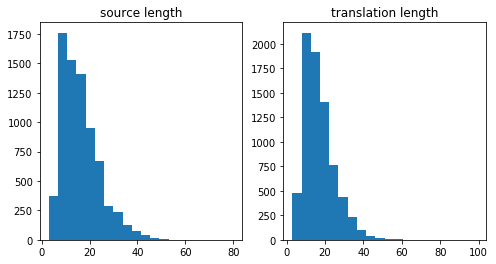

In [15]:
src_length = list(map(len, [x.src for x in test_data.examples]))
trg_length = list(map(len, [x.trg for x in test_data.examples]))

print('Length distribution in Test data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device(DEVICE_NAME if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [17]:
def _len_sort_key(x):
    return len(x.src)

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
PAD_IDX = TRG.vocab.stoi['<pad>']

In [21]:
def eval_bleu(model, test_iterator, target_vocab=TRG.vocab, with_tqdm=True):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        test_iterator = tqdm(enumerate(test_iterator)) if with_tqdm else enumerate(test_iterator)
        for i, batch in test_iterator:
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, target_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, target_vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [22]:
def get_teacher_forcing_ratio(epoch, base_teacher_forcing_ratio=0.5, decay=1):
    return base_teacher_forcing_ratio * decay ** epoch

In [23]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):        
        src = batch.src # [src sent len, batch size]
        trg = batch.trg # [trg sent len, batch size]
        
        optimizer.zero_grad()        
        teacher_forcing_ratio = get_teacher_forcing_ratio(epoch)
        output = model(src, trg, teacher_forcing_ratio) # [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            # [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
def training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip, n_epochs):
    best_valid_bleu = float('-inf')
    for epoch in tqdm(range(n_epochs)):    
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, clip, epoch)
        valid_loss = evaluate(model, valid_iterator, criterion)
        lr_scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        valid_bleu = eval_bleu(model, valid_iterator, with_tqdm=False)
        if valid_bleu > best_valid_bleu:
            best_valid_bleu = valid_bleu
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        writer.add_scalar('Train loss',
                    train_loss,
                    epoch)
        writer.add_scalar('Validation loss',
                    valid_loss,
                    epoch)
        writer.add_scalar('Validation BLEU',
                    valid_bleu,
                    epoch)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f} |  Val. BLEU: {valid_bleu:.3f}')

In [27]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

In [28]:
def print_samples(model, test_iterator, indices=range(1, 3)):
    batch = next(iter(test_iterator))
    for idx in indices:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        generate_translation(src, trg, model, TRG.vocab)

## Let's add attention to baseline

In [29]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [30]:
class GruEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, hidden=None):        
        # src = [src sent len, batch size]        
        embedded = self.embedding(src) # [src sent len, batch size, emb dim]
        embedded = self.dropout(embedded)
        
        if hidden is None:
            output, hidden = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded, hidden)
        
        # output = [src sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        return hidden

In [31]:
from torchnlp.nn.attention import Attention

class AttentionGruDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.attention = Attention(dimensions=n_layers*hid_dim, attention_type='general')
        
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.out = nn.Linear(
            in_features=n_layers*hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, encoder_outputs):        
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # encoder_outputs = [batch size, src sent len, dimensions = n layers * hid dim]
        
        batch_size = input.shape[0]        
        input = input.unsqueeze(0) # [1, batch size]
        
        embedded = self.dropout(self.embedding(input)) # [1, batch size, emb dim]
        
        output, hidden = self.rnn(embedded, hidden)
        # output = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        # [batch size, output length = 1, dimensions = n layers * n directions * hid dim]
        query = hidden.permute(1, 0, 2).reshape(batch_size, 1, self.n_layers * self.hid_dim)
        
        # [batch size, output length = 1, dimensions = n layers * hid dim]
        attention_output, _ = self.attention(query, encoder_outputs)
        
        # [batch size, dimensions = n layers * hid dim]
        attention_output = attention_output.squeeze(1)
        
        # [batch size, output dim]
        prediction = self.out(attention_output)
        
        return prediction, hidden

In [32]:
class AttentionGruSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        decoder_outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_state_size = self.encoder.n_layers * self.encoder.hid_dim
        
        # [src sent len, batch size, dimensions = n layers * hid dim]
        encoder_states = torch.zeros(src.shape[0], batch_size, encoder_state_size).to(self.device)
        
        first_encoder_input = src[0].unsqueeze(0) # [1, batch size]
        hidden = self.encoder(first_encoder_input) # [n layers * n directions, batch size, hid dim]
        # [batch size, n layers * n directions * hid dim]
        encoder_states[0] = hidden.permute(1,0,2).reshape(batch_size, encoder_state_size)
        
        for t in range(1, src.shape[0]):
            hidden = self.encoder(src[t].unsqueeze(0), hidden)
            encoder_states[t] = hidden.permute(1,0,2).reshape(batch_size, encoder_state_size)
        
        # [batch size, src sent len, dimensions = n layers * hid dim]
        encoder_states = encoder_states.permute(1, 0, 2)
        
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):            
            output, hidden = self.decoder(input, hidden, encoder_states)
            decoder_outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return decoder_outputs

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

LR = 1e-3
CLIP = 1
N_EPOCHS = 30

In [34]:
enc = GruEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionGruDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionGruSeq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

AttentionGruSeq2Seq(
  (encoder): GruEncoder(
    (embedding): Embedding(9256, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionGruDecoder(
    (embedding): Embedding(6734, 256)
    (attention): Attention(
      (linear_in): Linear(in_features=1024, out_features=1024, bias=False)
      (linear_out): Linear(in_features=2048, out_features=1024, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1024, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
count_parameters(model)

19658830

In [36]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [37]:
tensorboard_dir = get_tensorboard_dir(model_name)
print(tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip=CLIP, n_epochs=N_EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]

runs/gru_attention_2020-05-26--23-50-48


  3%|▎         | 1/30 [02:15<1:05:23, 135.30s/it]

Epoch: 01 | Time: 2m 12s
	Train Loss: 4.209 | Train PPL:  67.322
	 Val. Loss: 4.706 |  Val. PPL: 110.616 |  Val. BLEU: 17.175


  7%|▋         | 2/30 [04:30<1:03:11, 135.41s/it]

Epoch: 02 | Time: 2m 12s
	Train Loss: 3.180 | Train PPL:  24.050
	 Val. Loss: 4.550 |  Val. PPL:  94.679 |  Val. BLEU: 24.819


 10%|█         | 3/30 [06:47<1:01:03, 135.68s/it]

Epoch: 03 | Time: 2m 13s
	Train Loss: 2.865 | Train PPL:  17.554
	 Val. Loss: 4.275 |  Val. PPL:  71.891 |  Val. BLEU: 26.980


 13%|█▎        | 4/30 [09:02<58:40, 135.40s/it]  

Epoch: 04 | Time: 2m 11s
	Train Loss: 2.631 | Train PPL:  13.888
	 Val. Loss: 4.433 |  Val. PPL:  84.147 |  Val. BLEU: 29.273


 17%|█▋        | 5/30 [11:17<56:28, 135.54s/it]

Epoch: 05 | Time: 2m 12s
	Train Loss: 2.463 | Train PPL:  11.739
	 Val. Loss: 4.427 |  Val. PPL:  83.704 |  Val. BLEU: 30.453


 20%|██        | 6/30 [13:33<54:11, 135.50s/it]

Epoch: 06 | Time: 2m 13s
	Train Loss: 2.343 | Train PPL:  10.418
	 Val. Loss: 4.279 |  Val. PPL:  72.166 |  Val. BLEU: 29.137


 23%|██▎       | 7/30 [15:48<51:53, 135.39s/it]

Epoch: 07 | Time: 2m 12s
	Train Loss: 2.061 | Train PPL:   7.854
	 Val. Loss: 4.264 |  Val. PPL:  71.075 |  Val. BLEU: 33.149


 27%|██▋       | 8/30 [18:05<49:49, 135.91s/it]

Epoch: 08 | Time: 2m 14s
	Train Loss: 1.940 | Train PPL:   6.959
	 Val. Loss: 4.347 |  Val. PPL:  77.250 |  Val. BLEU: 33.020


 30%|███       | 9/30 [20:24<47:50, 136.70s/it]

Epoch: 09 | Time: 2m 15s
	Train Loss: 1.866 | Train PPL:   6.460
	 Val. Loss: 4.285 |  Val. PPL:  72.584 |  Val. BLEU: 33.365


 33%|███▎      | 10/30 [22:42<45:44, 137.21s/it]

Epoch: 10 | Time: 2m 15s
	Train Loss: 1.838 | Train PPL:   6.284
	 Val. Loss: 4.330 |  Val. PPL:  75.955 |  Val. BLEU: 33.806


 37%|███▋      | 11/30 [25:01<43:39, 137.89s/it]

Epoch: 11 | Time: 2m 16s
	Train Loss: 1.723 | Train PPL:   5.604
	 Val. Loss: 4.353 |  Val. PPL:  77.720 |  Val. BLEU: 34.288


 40%|████      | 12/30 [27:17<41:11, 137.29s/it]

Epoch: 12 | Time: 2m 13s
	Train Loss: 1.712 | Train PPL:   5.540
	 Val. Loss: 4.370 |  Val. PPL:  79.006 |  Val. BLEU: 34.262


 43%|████▎     | 13/30 [29:34<38:50, 137.10s/it]

Epoch: 13 | Time: 2m 13s
	Train Loss: 1.665 | Train PPL:   5.287
	 Val. Loss: 4.342 |  Val. PPL:  76.887 |  Val. BLEU: 34.387


 47%|████▋     | 14/30 [31:50<36:30, 136.91s/it]

Epoch: 14 | Time: 2m 14s
	Train Loss: 1.659 | Train PPL:   5.253
	 Val. Loss: 4.372 |  Val. PPL:  79.191 |  Val. BLEU: 34.189


 50%|█████     | 15/30 [34:06<34:09, 136.60s/it]

Epoch: 15 | Time: 2m 13s
	Train Loss: 1.657 | Train PPL:   5.243
	 Val. Loss: 4.363 |  Val. PPL:  78.504 |  Val. BLEU: 34.315


 53%|█████▎    | 16/30 [36:23<31:50, 136.50s/it]

Epoch: 16 | Time: 2m 13s
	Train Loss: 1.640 | Train PPL:   5.157
	 Val. Loss: 4.391 |  Val. PPL:  80.690 |  Val. BLEU: 34.576


 57%|█████▋    | 17/30 [38:39<29:34, 136.53s/it]

Epoch: 17 | Time: 2m 14s
	Train Loss: 1.651 | Train PPL:   5.211
	 Val. Loss: 4.366 |  Val. PPL:  78.719 |  Val. BLEU: 34.539


 60%|██████    | 18/30 [40:56<27:19, 136.64s/it]

Epoch: 18 | Time: 2m 14s
	Train Loss: 1.641 | Train PPL:   5.158
	 Val. Loss: 4.368 |  Val. PPL:  78.861 |  Val. BLEU: 34.524


 63%|██████▎   | 19/30 [43:13<25:03, 136.70s/it]

Epoch: 19 | Time: 2m 14s
	Train Loss: 1.647 | Train PPL:   5.190
	 Val. Loss: 4.364 |  Val. PPL:  78.564 |  Val. BLEU: 34.485


 67%|██████▋   | 20/30 [45:31<22:50, 137.01s/it]

Epoch: 20 | Time: 2m 15s
	Train Loss: 1.623 | Train PPL:   5.068
	 Val. Loss: 4.365 |  Val. PPL:  78.682 |  Val. BLEU: 34.564


 70%|███████   | 21/30 [47:49<20:37, 137.51s/it]

Epoch: 21 | Time: 2m 15s
	Train Loss: 1.627 | Train PPL:   5.090
	 Val. Loss: 4.369 |  Val. PPL:  78.990 |  Val. BLEU: 34.637


 73%|███████▎  | 22/30 [50:07<18:20, 137.59s/it]

Epoch: 22 | Time: 2m 14s
	Train Loss: 1.655 | Train PPL:   5.232
	 Val. Loss: 4.360 |  Val. PPL:  78.285 |  Val. BLEU: 34.698


 77%|███████▋  | 23/30 [52:23<15:58, 136.98s/it]

Epoch: 23 | Time: 2m 13s
	Train Loss: 1.614 | Train PPL:   5.021
	 Val. Loss: 4.365 |  Val. PPL:  78.662 |  Val. BLEU: 34.672


 80%|████████  | 24/30 [54:39<13:41, 136.87s/it]

Epoch: 24 | Time: 2m 14s
	Train Loss: 1.631 | Train PPL:   5.111
	 Val. Loss: 4.363 |  Val. PPL:  78.466 |  Val. BLEU: 34.633


 83%|████████▎ | 25/30 [56:55<11:22, 136.56s/it]

Epoch: 25 | Time: 2m 13s
	Train Loss: 1.641 | Train PPL:   5.161
	 Val. Loss: 4.365 |  Val. PPL:  78.674 |  Val. BLEU: 34.632


 87%|████████▋ | 26/30 [59:12<09:06, 136.66s/it]

Epoch: 26 | Time: 2m 14s
	Train Loss: 1.667 | Train PPL:   5.297
	 Val. Loss: 4.363 |  Val. PPL:  78.490 |  Val. BLEU: 34.634


 90%|█████████ | 27/30 [1:01:29<06:49, 136.61s/it]

Epoch: 27 | Time: 2m 14s
	Train Loss: 1.619 | Train PPL:   5.046
	 Val. Loss: 4.364 |  Val. PPL:  78.573 |  Val. BLEU: 34.641


 93%|█████████▎| 28/30 [1:03:45<04:32, 136.43s/it]

Epoch: 28 | Time: 2m 13s
	Train Loss: 1.630 | Train PPL:   5.105
	 Val. Loss: 4.365 |  Val. PPL:  78.624 |  Val. BLEU: 34.642


 97%|█████████▋| 29/30 [1:06:01<02:16, 136.54s/it]

Epoch: 29 | Time: 2m 14s
	Train Loss: 1.627 | Train PPL:   5.087
	 Val. Loss: 4.364 |  Val. PPL:  78.568 |  Val. BLEU: 34.640


100%|██████████| 30/30 [1:08:17<00:00, 136.14s/it]

Epoch: 30 | Time: 2m 13s
	Train Loss: 1.633 | Train PPL:   5.120
	 Val. Loss: 4.365 |  Val. PPL:  78.672 |  Val. BLEU: 34.633


**Let's load best model**

In [38]:
with open(f'models/{model_name}.pt', 'rb') as fp:
    best_state_dict = torch.load(fp, map_location='cpu')
    model.load_state_dict(best_state_dict)

**And look at its predictions**

In [39]:
print_samples(model, test_iterator, range(10))

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: free private parking is available .
Generated: free private parking is available on site .

Original: there are several restaurants in the surrounding area .
Generated: restaurants can be found in the vicinity .

Original: the property also offers free parking .
Generated: the property offers free parking .

Original: the unit is fitted with a kitchen .
Generated: the kitchen is a kitchen .

Original: the bathroom has a shower .
Generated: the bathroom comes with a shower .

Original: there is also a fireplace in the living room .
Generated: the living room has a fireplace .

Original: you will find a coffee mac

In [40]:
print('Test BLEU:', eval_bleu(model, test_iterator))

59it [00:04,  6.00it/s]


Test BLEU: 33.539300221021364


**And plot train/val metrics**

In [41]:
logs = parse_tensorboard_logs(tensorboard_dir)

In [42]:
printable_model_name = '_'.join(model_name.split('_')[:-1])

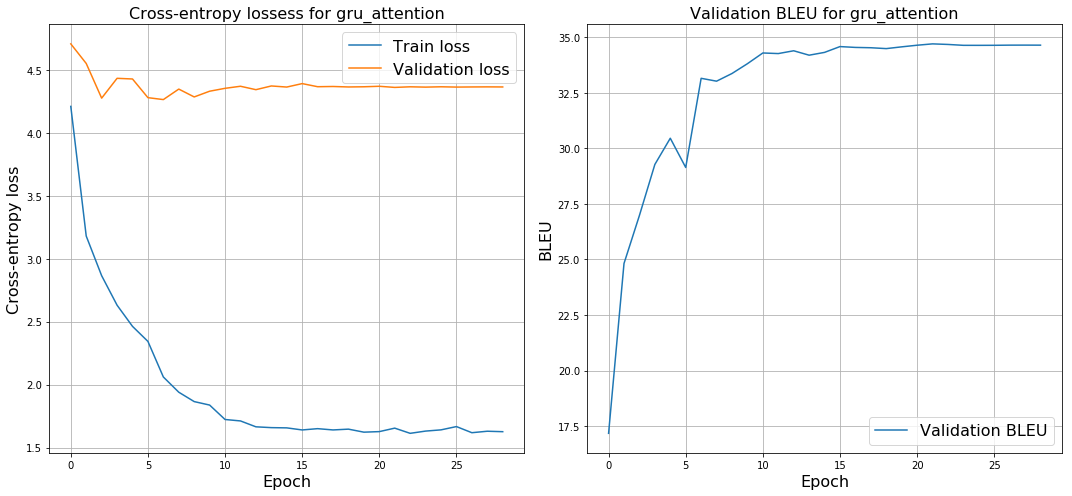

In [45]:
plot_metrics(logs, printable_model_name)